<h1>Thêm thư viện cần thiết

In [32]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.svm import SVR
from sklearn.utils import column_or_1d

warnings.filterwarnings('ignore')


<h1>Nạp dữ liệu

In [7]:
df = pd.read_csv("../Dataset/BTC-USD.csv", parse_dates=True,
                 index_col=0).drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'])

df_index = df.index
df.head()


,Close
Date,
2021-06-05,35551.957031
2021-06-06,35862.378906
2021-06-07,33560.707031
2021-06-08,33472.632812
2021-06-09,37345.121094


# Tạo mới cột Timestamp để dự báo theo chuỗi thời gian

In [8]:
df['Timestamp'] = pd.to_datetime(df.index).astype(np.int64) / 10**9
df.head()

,Close,Timestamp
Date,,
2021-06-05,35551.957031,1.622851e+09
2021-06-06,35862.378906,1.622938e+09
2021-06-07,33560.707031,1.623024e+09
2021-06-08,33472.632812,1.623110e+09
2021-06-09,37345.121094,1.623197e+09


# Vẽ đồ thị

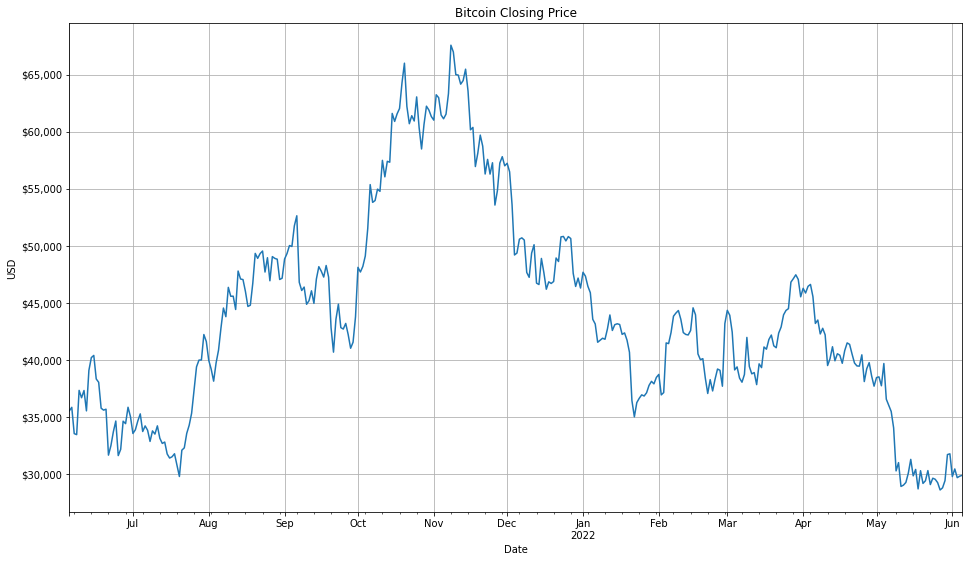

In [12]:
formatter = ticker.StrMethodFormatter('${x:,.0f}')

title = 'Bitcoin Closing Price'
ylabel = 'USD'
xlabel = 'Date'

ax = df['Close'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)


# Thực hiện xây dựng mô hình SVR

## Cần chuẩn hóa dữ liệu để thuận tiện cho việc xây dựng mô hình

In [20]:
X_sc = StandardScaler()
y_sc = StandardScaler()

X = df.iloc[:, 1].values.reshape(-1, 1)
y = df.iloc[:, 0].values.reshape(-1, 1)


X_scaled = X_sc.fit_transform(X)
y_scaled = y_sc.fit_transform(y)


df_scaled = pd.DataFrame(index=df_index)
df_scaled['Timestamp'] = X_scaled
df_scaled['Close'] = y_scaled
df_scaled.head()

,Timestamp,Close
Date,,
2021-06-05,-1.727325,-0.903048
2021-06-06,-1.717860,-0.868956
2021-06-07,-1.708395,-1.121731
2021-06-08,-1.698930,-1.131403
2021-06-09,-1.689466,-0.706119


## Chia dữ liệu thành tập train và tập test

In [21]:
train_data, test_data = df_scaled[df_scaled.index < '2022-01-01'], df_scaled[df_scaled.index >= '2022-01-01']
index_test = df_scaled.index[df_scaled.index >= '2022-01-01']
print(train_data.shape)
print(test_data.shape)


(210, 2)
(156, 2)


In [24]:
train_data.tail()

,Timestamp,Close
Date,,
2021-12-27,0.212958,0.753998
2021-12-28,0.222423,0.418869
2021-12-29,0.231887,0.293217
2021-12-30,0.241352,0.373762
2021-12-31,0.250817,0.278032


In [25]:
test_data.head()

,Timestamp,Close
Date,,
2022-01-01,0.260282,0.429627
2022-01-02,0.269747,0.392113
2022-01-03,0.279211,0.294689
2022-01-04,0.288676,0.233129
2022-01-05,0.298141,-0.022599


In [42]:
X_train, y_train = train_data['Timestamp'].values.reshape(-1, 1), train_data['Close'].values.reshape(-1, 1)
X_test, y_test = test_data['Timestamp'].values.reshape(-1, 1), test_data['Close'].values.reshape(-1, 1)


## Hàm tạo hyperparameters

In [27]:
def para_range(minimum, maximum, step):
    para_list = np.arange(minimum, maximum, step)
    return para_list


In [30]:
def print_stats(hyperparams, stats):
    if(hyperparams[0] == 'poly'):
        print(
            f'SVR(kernel={hyperparams[0]}, C={hyperparams[1]}, gamma={hyperparams[2]}, degree={hyperparams[3]}')
    else:
        print(
            f'SVR(kernel={hyperparams[0]}, C={hyperparams[1]}, gamma={hyperparams[2]}')

    print(
        f"MAE={stats[0]:.2f} | MAPE={stats[1]:.2f} | MSE={stats[2] :.2f} | RMSE={stats[3]:.2f}")


In [31]:
kernels = ['sigmoid', 'rbf', 'poly']
Cs = para_range(0.01, 0.2, 0.1)
gammas = para_range(0.1, 5, 0.1)
degrees = para_range(1, 6, 1)


## GridSearch để tìm hyperparameters phù hợp

In [48]:
warnings.filterwarnings('ignore')

stats_df = pd.DataFrame(
    columns=['kernel', 'C', 'gamma', 'degree', 'MAE', 'MAPE', 'MSE', 'RMSE'])

# Sử dụng gird-seach để tìm hyperparameters phù hợp
for ker in kernels:
    # Nếu kernel == poly thì thực hiện chọn degree
    if(ker != 'poly'):
        for C in Cs:
            for gamma in gammas:
                rgs = SVR(kernel=ker, C=C, gamma=gamma, verbose=False)
                rgs.fit(X_train, y_train)
                pred = rgs.predict(X_test)

                # Đảo tỷ lệ thành giá trị thực
                inv_pred = y_sc.inverse_transform(
                    column_or_1d(pred).reshape(-1, 1))
                inv_test = y_sc.inverse_transform(
                    column_or_1d(y_test).reshape(-1, 1))
                    
                # Đánh giá mô hình
                mae = mean_absolute_error(inv_test, inv_pred)
                mape = mean_absolute_percentage_error(inv_test, inv_pred)
                mse = mean_squared_error(inv_test, inv_pred)
                rmse = np.sqrt(mse)

                result = {'kernel': ker, 'C': C, 'gamma': gamma, 'degree': 0,
                          'MAE': mae, 'MAPE': mape, 'MSE': mse, 'RMSE': rmse}

                hyperparam = [ker, C, gamma, 0]
                stats = [mae, mape, mse, rmse]
                stats_df = stats_df.append(result, ignore_index=True)
                print_stats(hyperparam, stats)
    else:
        for C in Cs:
            for gamma in gammas:
                for deg in degrees:
                    rgs = SVR(kernel=ker, C=C, gamma=gamma, verbose=False)
                    rgs.fit(X_train, y_train.reshape(-1, 1))
                    pred = rgs.predict(X_test)

                    # Đảo tỷ lệ thành giá trị thực
                    inv_pred = y_sc.inverse_transform(
                        column_or_1d(pred).reshape(-1, 1))
                    inv_test = y_sc.inverse_transform(
                        column_or_1d(y_test).reshape(-1, 1))

                    # Đánh giá mô hình
                    mae = mean_absolute_error(inv_test, inv_pred)
                    mape = mean_absolute_percentage_error(inv_test, inv_pred)
                    mse = mean_squared_error(inv_test, inv_pred)
                    rmse = np.sqrt(mse)

                    result = {'kernel': ker, 'C': C, 'gamma': gamma, 'degree': 0,
                            'MAE': mae, 'MAPE': mape, 'MSE': mse, 'RMSE': rmse}

                    hyperparam = [ker, C, gamma, 0]
                    stats = [mae, mape, mse, rmse]

                    stats_df = stats_df.append(result, ignore_index=True)

                    print_stats(hyperparam, stats)


SVR(kernel=sigmoid, C=0.01, gamma=0.1
MAE=9263.54 | MAPE=0.26 | MSE=113839227.92 | RMSE=10669.55
SVR(kernel=sigmoid, C=0.01, gamma=0.2
MAE=10101.25 | MAPE=0.28 | MSE=131449369.81 | RMSE=11465.14
SVR(kernel=sigmoid, C=0.01, gamma=0.30000000000000004
MAE=10883.60 | MAPE=0.31 | MSE=148668387.59 | RMSE=12192.96
SVR(kernel=sigmoid, C=0.01, gamma=0.4
MAE=11227.57 | MAPE=0.31 | MSE=156316451.35 | RMSE=12502.66
SVR(kernel=sigmoid, C=0.01, gamma=0.5
MAE=11607.47 | MAPE=0.32 | MSE=164678471.41 | RMSE=12832.71
SVR(kernel=sigmoid, C=0.01, gamma=0.6
MAE=11988.99 | MAPE=0.33 | MSE=173048960.11 | RMSE=13154.81
SVR(kernel=sigmoid, C=0.01, gamma=0.7000000000000001
MAE=12161.52 | MAPE=0.34 | MSE=176352534.88 | RMSE=13279.78
SVR(kernel=sigmoid, C=0.01, gamma=0.8
MAE=12186.73 | MAPE=0.34 | MSE=175982738.48 | RMSE=13265.85
SVR(kernel=sigmoid, C=0.01, gamma=0.9
MAE=12193.74 | MAPE=0.34 | MSE=175324266.79 | RMSE=13241.01
SVR(kernel=sigmoid, C=0.01, gamma=1.0
MAE=12116.99 | MAPE=0.34 | MSE=172649771.20 | RMSE

In [49]:
best_fit_model = stats_df[stats_df['RMSE']
                          == stats_df['RMSE'].min()]
best_fit_model


,kernel,C,gamma,degree,MAE,MAPE,MSE,RMSE
158,rbf,0.11,1.2,0,5108.125566,0.148403,44875228.181267,6698.897535


In [52]:
kernel = str(best_fit_model['kernel'].values[0])
C = float(best_fit_model['C'])
gamma = float(best_fit_model['gamma'])
degree = int(best_fit_model['degree'])

if(kernel == 'poly'):
    rgs = SVR(kernel=kernel, C=C, gamma=gamma, degree=degree)
else:
    rgs = SVR(kernel=kernel, C=C, gamma=gamma)

rgs.fit(X_train, y_train)
pred = rgs.predict(X_test)
pred

array([ 0.55449626,  0.53454996,  0.51470219,  0.49496501,  0.47535022,
        0.45586933,  0.4365336 ,  0.41735397,  0.3983411 ,  0.37950534,
        0.36085676,  0.34240507,  0.32415969,  0.3061297 ,  0.28832385,
        0.27075057,  0.25341794,  0.23633369,  0.21950522,  0.20293956,
        0.18664343,  0.17062315,  0.15488473,  0.13943381,  0.12427567,
        0.10941525,  0.09485713,  0.08060555,  0.06666439,  0.05303718,
        0.03972713,  0.02673707,  0.01406953,  0.00172667, -0.01028965,
       -0.02197793, -0.03333696, -0.04436586, -0.05506409, -0.06543136,
       -0.07546775, -0.08517357, -0.09454947, -0.10359635, -0.11231541,
       -0.1207081 , -0.12877614, -0.13652151, -0.14394642, -0.15105335,
       -0.15784497, -0.16432421, -0.1704942 , -0.17635827, -0.18191997,
       -0.18718302, -0.19215134, -0.19682901, -0.20122028, -0.20532956,
       -0.2091614 , -0.2127205 , -0.2160117 , -0.21903992, -0.22181026,
       -0.22432786, -0.22659801, -0.22862606, -0.23041746, -0.23

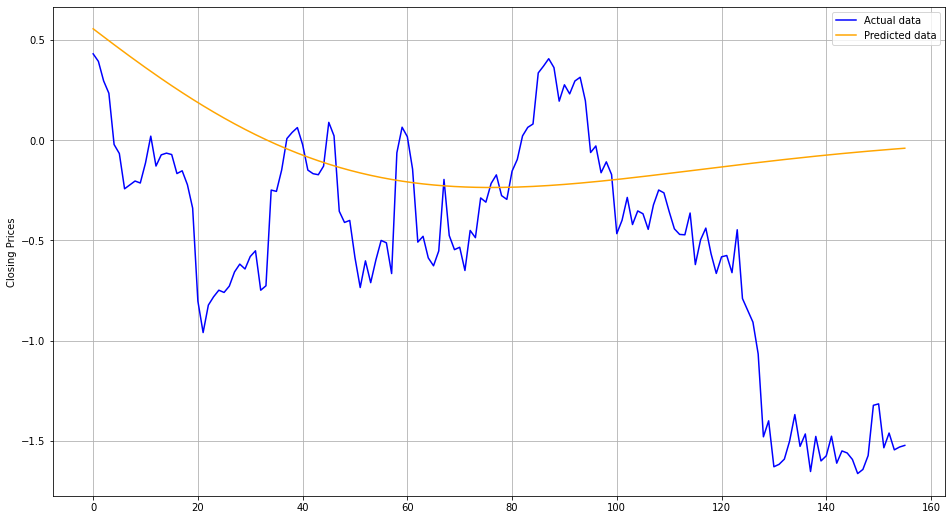

In [56]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Closing Prices')
plt.plot(column_or_1d(y_test), 'blue', label='Actual data')
plt.plot(column_or_1d(pred), 'orange', label='Predicted data')
plt.legend()


<h1>Đưa dữ liệu về miền giá trị ban đầu

In [57]:
inv_pred = y_sc.inverse_transform(pred.reshape(-1, 1))
inv_test = y_sc.inverse_transform(y_test.reshape(-1, 1))


# Đánh giá mô hình

In [59]:
mae = mean_absolute_error(inv_test, inv_pred)
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 5108.13
MAPE: 14.84%
MSE: 44875228.18
RMSE: 6698.90
